# Quantization Aware Training with diff quant function
https://openaccess.thecvf.com/content_CVPR_2019/papers/Yang_Quantization_Networks_CVPR_2019_paper.pdf


https://github.com/aliyun/alibabacloud-quantization-networks/tree/master

## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from models.quantization import Quantization
import matplotlib.pyplot as plt
from torch.nn.utils.parametrize import register_parametrization as rpm
from tqdm.notebook import tqdm
import numpy as np

In [2]:
%load_ext autoreload
%autoreload 2

## Models

In [3]:
class QuantizedModule(nn.Module):
    """
    Parametrization of the weights of a layer with quantization

    Args:
        mask (torch.tensor): mask for the weights
    """

    def __init__(self, n_bits):
        super().__init__()
        self.quant_values = np.linspace(
            -(2 ** (n_bits - 1)), 2 ** (n_bits - 1) - 1, 2**n_bits
        )
        self.quant = Quantization(
            quant_values=self.quant_values,
        )

    def forward(self, W):
        return self.quant(W)


class Net(nn.Module):
    def __init__(self, n_bits=None, **kwargs):
        super(Net, self).__init__()

        self.modules_dict = nn.ModuleDict(
            {
                "conv1": nn.Conv2d(1, 32, 3, 1),
                "relu1": nn.ReLU(),
                "mp1": nn.MaxPool2d(2),
                "conv2": nn.Conv2d(32, 64, 3, 1),
                "relu2": nn.ReLU(),
                "mp2": nn.MaxPool2d(2),
                "fc1": nn.Linear(1600, 128),
                "relu3": nn.ReLU(),
                "fc2": nn.Linear(128, 10),
            }
        )

        # self.modules_list = [
        #     nn.Linear(28 * 28, 128, bias=False),
        #     nn.ReLU(),
        #     nn.Linear(128, 10, bias=False),
        # ]

        self.quantization = n_bits is not None
        if self.quantization:
            self.n_bits = n_bits
            self.activations = {}
            self.quantize_activations = kwargs.get("quantize_activations", False)

            for n, m in self.modules_dict.items():
                if hasattr(m, "weight"):
                    rpm(m, "weight", QuantizedModule(n_bits))
                    if self.quantize_activations:
                        self.activations[n] = QuantizedModule(n_bits)

            if self.quantize_activations:
                self.activations = nn.ModuleDict(self.activations)

    def set_temperature(self, T):
        for n, m in self.named_modules():
            if hasattr(m, "T"):
                m.T = T

    def set_training(self, training):
        for n, m in self.named_modules():
            if hasattr(m, "training"):
                m.training = training

    @property
    def original_weights(self):
        return {
            n: m.parametrizations.weight.original
            for n, m in self.named_modules()
            if hasattr(m, "parametrizations")
        }

    @property
    def n_layers(self):
        return len([m for m in self.modules_dict.values() if hasattr(m, "weight")])

    def forward(self, x):

        for name, module in self.modules_dict.items():
            if isinstance(module, nn.Linear) and len(x.shape) > 2:
                x = x.view(x.size(0), -1)
            x = module(x)
            if (
                self.quantization
                and self.quantize_activations
                and name in self.activations
            ):
                x = self.activations[name](x)
        output = F.log_softmax(x, dim=1)
        return output

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

### Examples :

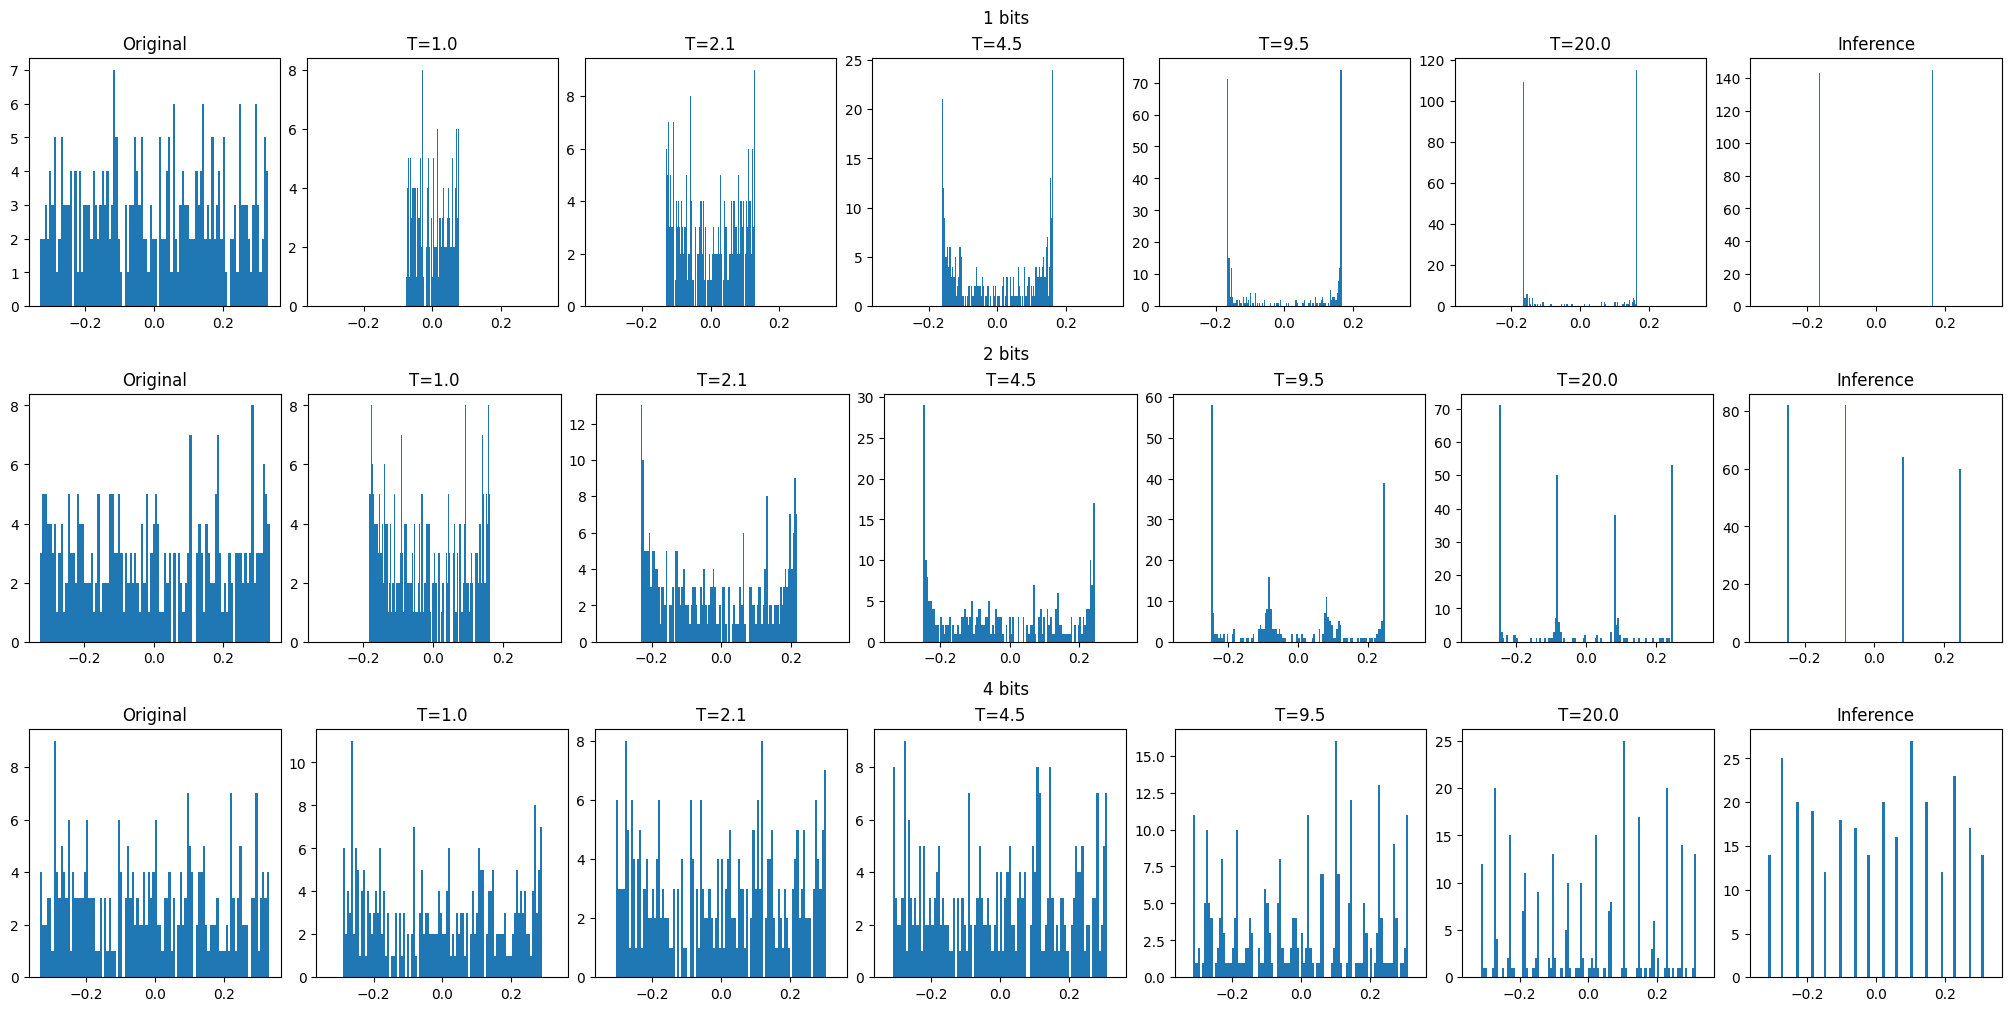

In [5]:
n_bits = [1, 2, 4]
Ts = np.geomspace(1, 20, 5)

fig = plt.figure(figsize=(20, 10), constrained_layout=True)
subfigs = fig.subfigures(len(n_bits), 1)
if len(n_bits) == 1:
    subfigs = [subfigs]

for n, subfig in zip(n_bits, subfigs):
    axs_v = subfig.subplots(1, len(Ts) + 2,  sharex=True)
    subfig.suptitle(f"{n} bits")
    model = Net(quantization=True, n_bits=n)

    ax = axs_v[0]
    ax.hist(
        model.original_weights["modules_dict.conv1"].cpu().detach().numpy().flatten(),
        bins=100,
    )
    ax.set_title(f"Original")

    for T, ax in zip(Ts, axs_v[1:-1]):
        if model.quantization:
            model.set_temperature(T)
            model.set_training(True)
        ax.hist(model.modules_dict["conv1"].weight.cpu().detach().numpy().flatten(), bins=100)
        ax.set_title(f"T={T:.1f}")

    model.set_training(False)
    ax = axs_v[-1]
    ax.hist(model.modules_dict["conv1"].weight.cpu().detach().numpy().flatten(), bins=100)
    ax.set_title(f"Inference")

## Training

In [6]:
def train(model, device, train_loader, optimizer, epoch, **kwargs):
    model.train()
    train_losses, train_accs = [], []
    if hasattr(model, "quant"):
        model.set_training(True)
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if kwargs.get("adjust_T", False):
            model.set_temperature(
                kwargs.get("Ts")[(epoch - 1) * len(train_loader) + batch_idx]
            )

        desc = str(
            "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch,
                batch_idx * len(data),
                len(train_loader.dataset),
                100.0 * batch_idx / len(train_loader),
                loss.item(),
            )
        )

        train_losses.append(loss.item())
        pred = output.argmax(
            dim=1, keepdim=True
        )  # get the index of the max log-probability
        correct = pred.eq(target.view_as(pred)).sum().item()
        train_accs.append(correct / len(data))

        if kwargs.get("pbar", None):
            kwargs["pbar"].set_description(desc)

    return train_losses, train_accs, desc


def test(model, device, test_loader, pbar=None):
    model.eval()
    if hasattr(model, "quant"):
        model.set_training(False)
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(
                output, target, reduction="sum"
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    desc = str(
        "| Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss,
            correct,
            len(test_loader.dataset),
            100.0 * correct / len(test_loader.dataset),
        )
    )

    if pbar is not None:
        pbar.set_description(desc)

    return test_loss, correct / len(test_loader.dataset), desc

### Data

In [7]:
batch_size = 64
test_batch_size = 1000

train_kwargs = {"batch_size": batch_size}
test_kwargs = {"batch_size": test_batch_size}
if use_cuda:
    cuda_kwargs = {"num_workers": 1, "pin_memory": True, "shuffle": True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
)
dataset1 = datasets.MNIST("../data", train=True, download=True, transform=transform)
dataset2 = datasets.MNIST("../data", train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

### Init

In [8]:
n_bits = 2
quantize_activations = False

dropout = 0.2
q_model = Net(
    n_bits=n_bits, quantize_activations=quantize_activations, dropout=dropout
).to(device)
original_model = Net(dropout=dropout).to(device)

lr = 1e-3
gamma = 0.95

q_optimizer = optim.Adam(q_model.parameters(), lr=lr)
original_optimizer = optim.Adam(original_model.parameters(), lr=lr)

n_epochs = 4

Ts = np.geomspace(1, 20, n_epochs * len(train_loader) + 1)
adjust_T = True

q_scheduler = StepLR(q_optimizer, step_size=1, gamma=gamma)
original_scheduler = StepLR(original_optimizer, step_size=1, gamma=gamma)

results = {
    "quantized": {
        "train_losses": [],
        "train_accs": [],
        "test_losses": [],
        "test_accs": [],
    },
    "original": {
        "train_losses": [],
        "train_accs": [],
        "test_losses": [],
        "test_accs": [],
    },
}

In [9]:
data, target = next(iter(train_loader))
data, target = data.to(device), target.to(device)
out = q_model(data)

### Train !

In [10]:
for model, optimizer, scheduler, name in zip(
    [q_model, original_model],
    [q_optimizer, original_optimizer],
    [q_scheduler, original_scheduler],
    ["quantized", "original"],
):

    pbar = tqdm(range(0, n_epochs + 1))

    for epoch in pbar:

        if epoch > 0:
            train_loss, train_acc, _ = train(
                model,
                device,
                train_loader,
                optimizer,
                epoch,
                pbar=None,
                Ts=Ts,
                adjust_T=adjust_T,
            )
            results[name]["train_losses"].extend(train_loss)
            results[name]["train_accs"].extend(train_acc)
            scheduler.step()

        test_loss, test_acc, _ = test(model, device, test_loader, pbar=pbar)
        results[name]["test_losses"].append(test_loss)
        results[name]["test_accs"].append(test_acc)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

### Results

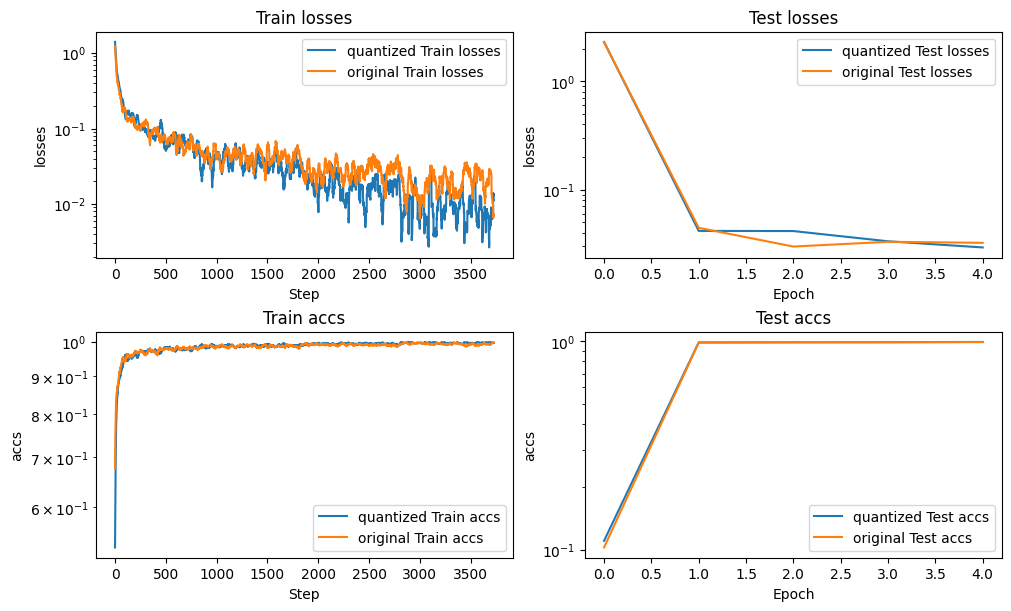

In [11]:
fig, axs = plt.subplots(
    2, 2, figsize=(10, 6), constrained_layout=True, sharex=False, sharey=False
)
for metric, axs_m in zip(["losses", "accs"], axs):
    for name in ["quantized", "original"]:
        for ax, trial in zip(axs_m, ["Train", "Test"]):

            res = results[name][f"{trial.lower()}_{metric}"]
            if trial == "Train":
                k = 25
                res = np.convolve(res, np.ones(k) / k, mode="valid")
            ax.plot(
                res,
                label=f"{name} {trial} {metric}",
            )
            ax.set_title(f"{trial} {metric}")
            ax.legend()
            ax.set_xlabel("Epoch" if trial == "Test" else "Step")
            ax.set_ylabel(metric)
            ax.set_yscale("log")
            # ax.set_xscale('log')

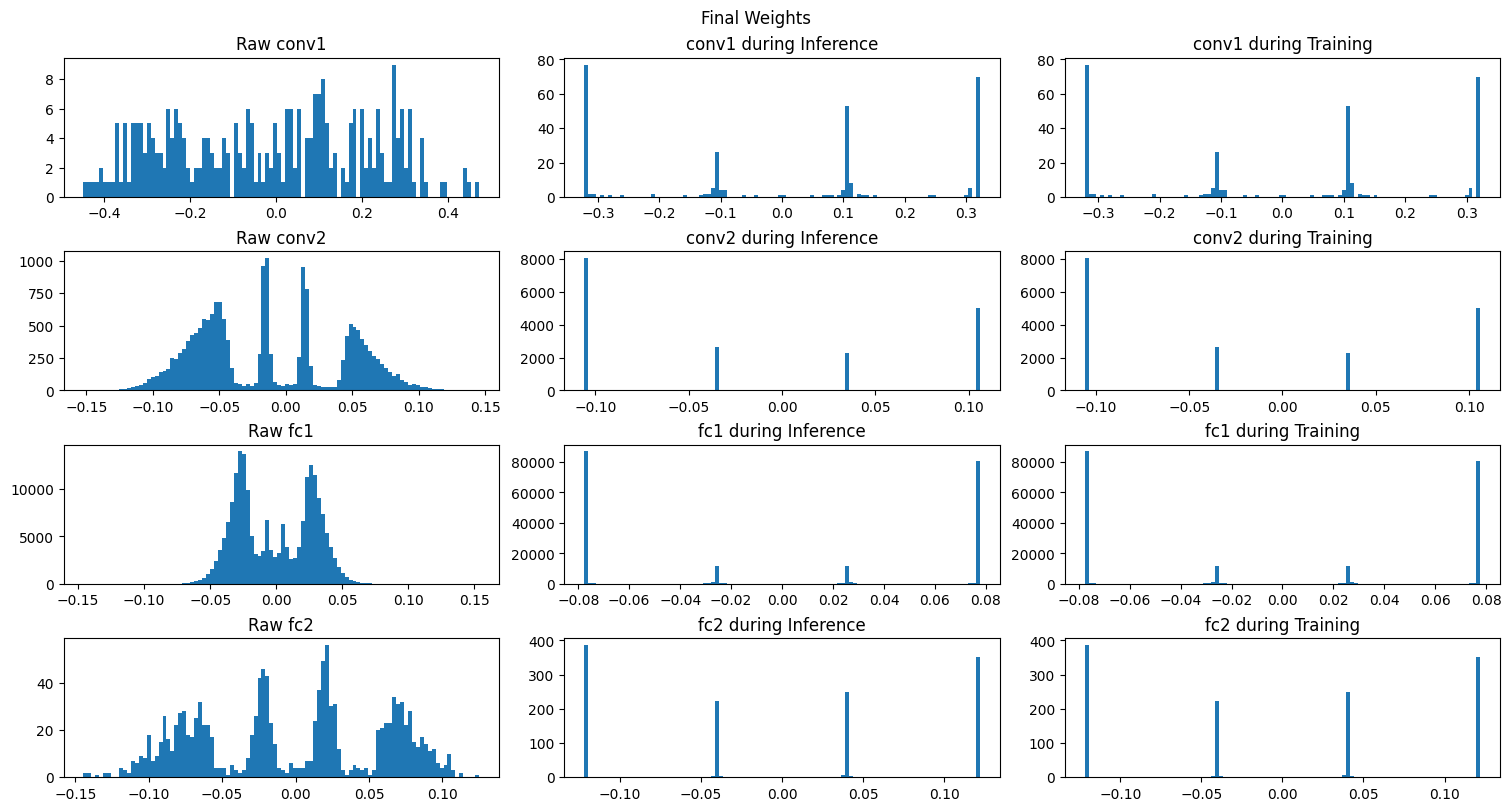

In [25]:
fig, axs = plt.subplots(
    q_model.n_layers, 3, constrained_layout=True, figsize=(15, 2 * q_model.n_layers)
)

for i, (axs_layer, (n, m)) in enumerate(
        zip(
            axs,
            {n: m for n, m in q_model.modules_dict.items() if hasattr(m, "weight")}.items(),
        )
    ):
        
        weights = m.weight.cpu().detach().numpy().flatten()

        for training, ax in enumerate(axs_layer[1:]):
            ax.hist(weights, bins=100)
            ax.set_title(
                f"{n} during {'Training'*training + 'Inference'*(1-training)}"
            )

        ax = axs_layer[0]
        ax.hist(
            q_model.original_weights[f'modules_dict.{n}'].cpu().detach().numpy().flatten(),
            bins=100,
        )
        ax.set_title(f"Raw {n}")

fig.suptitle("Final Weights")
plt.show()